In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/test1.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/train1.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203932 entries, 0 to 203931
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_id        203932 non-null  int64  
 1   date               203932 non-null  object 
 2   temperature        203932 non-null  float64
 3   precipitation      203932 non-null  float64
 4   windspeed          203932 non-null  float64
 5   humidity           203932 non-null  float64
 6   sunshine_hours     203932 non-null  float64
 7   solar_radiation    203932 non-null  float64
 8   power_consumption  203932 non-null  float64
 9   building_type      203932 non-null  object 
 10  total_floor_area   203932 non-null  float64
 11  solar_capacity     203932 non-null  float64
 12  ess_capacity       203932 non-null  float64
 13  pcs_capacity       203932 non-null  float64
 14  hour               203932 non-null  int64  
 15  dow                203932 non-null  int64  
 16  mo

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['building_type_encoded'] = le.fit_transform(train['building_type'])
test['building_type_encoded'] = le.fit_transform(test['building_type'])

print("클래스 목록:", le.classes_)
print(train[['building_type', 'building_type_encoded']].head())

클래스 목록: ['IDC(전화국)' '건물기타' '공공' '백화점' '병원' '상용' '아파트' '연구소' '학교' '호텔']
  building_type  building_type_encoded
0            호텔                      9
1            호텔                      9
2            호텔                      9
3            호텔                      9
4            호텔                      9


# 모델링

In [6]:
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','building_type',
                'power_consumption','windspeed','precipitation','date'], axis =1 )

Y = train[['power_consumption', 'building_type_encoded']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date','building_type',
                   'windspeed','precipitation', 'pred_solar_radiation', 'pred_sunshine_hours'], axis=1)

In [ ]:
'''
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','building_type', 'windspeed',
                'date'], axis =1 )

Y = train[['building_type_encoded','power_consumption']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date',
                   'building_type', 'windspeed','precipitation'], axis=1)
'''

KeyError: "['building_type_encoded'] not in index"

In [6]:
cat_cols = ["building_type", "rain_bin", "wind_bin"]

for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].astype("category").cat.codes
    if col in Y.columns:
        Y[col] = Y[col].astype("category").cat.codes
    if col in test_X.columns:
        test_X[col] = test_X[col].astype("category").cat.codes


## 유형별 모델 (building_type_encoded 별 KFold + XGBoost)

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

KFOLD_SPLITS = 5
RANDOM_SEED  = 42
DATA_DIR     = "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드"
target_col   = "power_consumption"

# 결과 그릇
type_list = X["building_type_encoded"].unique()
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df   = pd.DataFrame(index=Y.index,     columns=["pred"],   dtype=float)

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 유형별 학습/예측
for btype in type_list:
    # 유형 필터
    x_all  = X[X['building_type_encoded'] == btype].copy()
    y_all  = Y[Y['building_type_encoded'] == btype][target_col].copy()
    xt_all = test_X[test_X['building_type_encoded'] == btype].copy()

    # building_id 원핫 (train+test 합쳐 동일화)
    join = pd.concat([x_all, xt_all], axis=0, copy=False)
    join = pd.get_dummies(join, columns=["building_id"], drop_first=False)

    x  = join.iloc[:len(x_all)].copy()
    xt = join.iloc[len(x_all):].copy()

    # 불필요 열 제거
    drop_cols = ["building_type_encoded"]
    x  = x.drop(columns=[c for c in drop_cols if c in x.columns])
    xt = xt.drop(columns=[c for c in drop_cols if c in xt.columns])

    preds_valid = pd.Series(index=y_all.index, dtype=float)
    preds_test_each_fold = []

    x_values = x.values
    y_values = y_all.values

    fold_scores = []

    # 랜덤포레스트 하이퍼파라미터(성능/일반화 균형)
    rf_params = dict(
        n_estimators=1000,        # 충분히 많은 트리
        max_depth=None,           # 깊이 제한 없음(분산↑ 시 min_samples_leaf로 제어)
        max_features=0.5,         # 특성 일부만 사용 → 상호작용/일반화에 도움
        min_samples_leaf=5,       # 리프 최소 표본수로 과적합 억제
        min_samples_split=10,
        bootstrap=True,
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=0
    )

    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그 변환하여 학습(양수 타깃에 권장) → 예측 후 expm1 역변환
        y_tr_log = np.log1p(y_tr)

        model = RandomForestRegressor(**rf_params)
        model.fit(X_tr, y_tr_log)

        # 검증 예측
        va_pred_log = model.predict(X_va)
        va_pred     = np.expm1(va_pred_log)

        preds_valid.loc[y_all.index[va_idx]] = va_pred
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)

        # 테스트 예측
        xt_pred_log = model.predict(xt.values)
        xt_pred     = np.expm1(xt_pred_log)
        preds_test_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean_pred = np.mean(preds_test_each_fold, axis=0)

    # 적재
    pred_df.loc[preds_valid.index, "pred"] = preds_valid
    answer_df.loc[xt_all.index,     "answer"] = xt_mean_pred

    print(f"[{btype}] RF SMAPE(mean folds): {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape = smape(
    Y.sort_index()[target_col].values,
    pred_df.sort_index()["pred"].values
)
print(f"Total SMAPE (RandomForest) = {total_smape:.4f}")


[9] RF SMAPE(mean folds): 5.5899
[5] RF SMAPE(mean folds): 2.4882
[4] RF SMAPE(mean folds): 2.8698
[8] RF SMAPE(mean folds): 3.7667
[1] RF SMAPE(mean folds): 4.8010
[6] RF SMAPE(mean folds): 4.0122
[7] RF SMAPE(mean folds): 4.4370
[3] RF SMAPE(mean folds): 5.5835
[0] RF SMAPE(mean folds): 0.9646
[2] RF SMAPE(mean folds): 5.0006
Total SMAPE (RandomForest) = 4.0636


## 건물별 모델 (building_id 단위 KFold + XGBoost)

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

id_col     = 'building_id'
type_col   = 'building_type'
target_col = 'power_consumption'

def ensure_numeric(df, drop_cols=None):
    df = df.copy()
    if drop_cols:
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

drop_never = ['date']

# 원본 보존을 위해 사본 생성(숫자화)
X_num      = ensure_numeric(X, drop_cols=drop_never)
test_X_num = ensure_numeric(test_X, drop_cols=drop_never)

# 결과
answer_df_by_building = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_by_building   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

building_numbers = X_num[id_col].unique()

# 랜덤포레스트 하이퍼파라미터(일반화 지향)
rf_params = dict(
    n_estimators=1200,      # 트리 수 충분히 크게
    max_depth=None,         # 깊이 제한 없음(아래 두 파라미터로 규제)
    max_features=0.5,       # 무작위 특성 부분집합: 상호작용/일반화에 도움
    min_samples_leaf=5,     # 리프 최소 표본수로 과적합 억제
    min_samples_split=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

for bnum in building_numbers:
    # 필터
    x_b  = X_num[X_num[id_col] == bnum].copy()
    y_b  = train[train[id_col] == bnum][target_col].copy()
    xt_b = test_X_num[test_X_num[id_col] == bnum].copy()

    # 표본 체크
    n_samples = len(x_b)
    if n_samples < 2 or len(y_b) < 2:
        print(f"[SKIP] Building {bnum}: too few samples (n={n_samples}).")
        continue

    # 드롭: id/타입 등 모델 입력 제외
    drop_cols = [id_col, type_col]
    x_b  = x_b.drop(columns=[c for c in drop_cols if c in x_b.columns], errors='ignore')
    xt_b = xt_b.drop(columns=[c for c in drop_cols if c in xt_b.columns], errors='ignore')

    # train/test 컬럼 일치
    xt_b = xt_b.reindex(columns=x_b.columns, fill_value=0)

    # KFold 분할 수 안전 조정
    n_splits = min(KFOLD_SPLITS, n_samples)
    if n_splits < 2:
        print(f"[SKIP] Building {bnum}: not enough data for KFold (n={n_samples}).")
        continue
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    preds_valid_b = pd.Series(index=y_b.index, dtype=float)
    preds_test_b_each_fold = []

    X_values = x_b.values
    y_values = y_b.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_values), 1):
        X_tr, X_va = X_values[tr_idx], X_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그변환 타깃으로 학습 → 예측 후 expm1 역변환
        y_tr_log = np.log1p(y_tr)

        model = RandomForestRegressor(**rf_params)
        model.fit(X_tr, y_tr_log)

        # 검증 예측
        va_pred_log = model.predict(X_va)
        va_pred     = np.expm1(va_pred_log)

        preds_valid_b.loc[y_b.index[va_idx]] = va_pred
        fold_scores.append(smape(y_va, va_pred))

        # 테스트 예측
        xt_pred_log = model.predict(xt_b.values)
        xt_pred     = np.expm1(xt_pred_log)
        preds_test_b_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean = np.mean(preds_test_b_each_fold, axis=0)

    # 결과 적재
    pred_df_by_building.loc[preds_valid_b.index, "pred"] = preds_valid_b
    answer_df_by_building.loc[xt_b.index, "answer"] = xt_mean

    print(f"Building {bnum} | RF SMAPE(mean folds): {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape_by_building = smape(
    train.sort_index()[target_col].values,
    pred_df_by_building.sort_index()["pred"].values
)
print(f"Total SMAPE (by Building, RandomForest) = {total_smape_by_building:.4f}")


Building 1 | RF SMAPE(mean folds): 7.9774
Building 2 | RF SMAPE(mean folds): 5.1236
Building 3 | RF SMAPE(mean folds): 2.5510
Building 4 | RF SMAPE(mean folds): 4.9527
Building 5 | RF SMAPE(mean folds): 2.3466
Building 6 | RF SMAPE(mean folds): 6.8351
Building 7 | RF SMAPE(mean folds): 5.7608
Building 8 | RF SMAPE(mean folds): 5.1198
Building 9 | RF SMAPE(mean folds): 5.1848
Building 10 | RF SMAPE(mean folds): 5.2760
Building 11 | RF SMAPE(mean folds): 3.3448
Building 12 | RF SMAPE(mean folds): 2.7098
Building 13 | RF SMAPE(mean folds): 3.5927
Building 14 | RF SMAPE(mean folds): 2.9010
Building 15 | RF SMAPE(mean folds): 3.7189
Building 16 | RF SMAPE(mean folds): 2.5556
Building 17 | RF SMAPE(mean folds): 2.7233
Building 18 | RF SMAPE(mean folds): 3.8784
Building 19 | RF SMAPE(mean folds): 7.0592
Building 20 | RF SMAPE(mean folds): 1.0848
Building 21 | RF SMAPE(mean folds): 2.0179
Building 22 | RF SMAPE(mean folds): 3.9595
Building 23 | RF SMAPE(mean folds): 8.9939
Building 24 | RF SMA

## 글로벌 모델 (전체 데이터 한 번에 KFold + XGBoost)

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def ensure_all_numeric(df):
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

# 어떤 ID 컬럼이 있는지 확인
id_cols_candidates = ["building_number", "building_id"]
id_col = next((c for c in id_cols_candidates if c in X.columns), None)

# 타입 컬럼도 있으면 사용
type_col = "building_type" if "building_type" in X.columns else None
target_col = "power_consumption"

# 원-핫
x_global  = X.copy()
xt_global = test_X.copy()

# building_type 더미 (있을 때만)
if type_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[type_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[type_col], drop_first=False)

# building id 더미 (있을 때만)
if id_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[id_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[id_col], drop_first=False)

# 사용하지 않을 열 제거
drop_cols_global = ['date']
x_global  = x_global.drop(columns=[c for c in drop_cols_global if c in x_global.columns], errors='ignore')
xt_global = xt_global.drop(columns=[c for c in drop_cols_global if c in xt_global.columns], errors='ignore')

# train/test 컬럼 일치
xt_global = xt_global.reindex(columns=x_global.columns, fill_value=0)

# 남은 문자열/객체 열 숫자화
x_global  = ensure_all_numeric(x_global)
xt_global = ensure_all_numeric(xt_global)

# 타깃 정렬 (X와 같은 인덱스 순서)
y_global = train.loc[X.index, target_col].astype(float).copy()

# 결과
answer_df_global = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_global   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

preds_valid_global = pd.Series(index=y_global.index, dtype=float)
preds_test_global  = []

# KFold
n_samples = len(x_global)
n_splits  = min(KFOLD_SPLITS, n_samples)
if n_splits < 2:
    raise ValueError(f"Not enough samples for KFold: n={n_samples}")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

x_values_global = x_global.values
y_values_global = y_global.values

fold_scores_global = []

# 랜덤포레스트 하이퍼파라미터(일반화 지향)
rf_params = dict(
    n_estimators=1200,
    max_depth=None,
    max_features=0.5,      # 고차원 원-핫에 유리
    min_samples_leaf=5,
    min_samples_split=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values_global), 1):
    X_tr, X_va = x_values_global[tr_idx], x_values_global[va_idx]
    y_tr, y_va = y_values_global[tr_idx], y_values_global[va_idx]

    # 로그 변환 타깃으로 학습 → 예측 후 expm1 역변환
    y_tr_log = np.log1p(y_tr)

    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, y_tr_log)

    # 검증 예측
    va_pred_log = model.predict(X_va)
    va_pred     = np.expm1(va_pred_log)
    preds_valid_global.iloc[va_idx] = va_pred
    fold_scores_global.append(smape(y_va, va_pred))

    # 테스트 예측
    xt_pred_log = model.predict(xt_global.values)
    xt_pred     = np.expm1(xt_pred_log)
    preds_test_global.append(xt_pred)

# fold 평균으로 test 예측/적재
answer_df_global.loc[xt_global.index, "answer"] = np.mean(preds_test_global, axis=0)
pred_df_global.loc[preds_valid_global.index, "pred"] = preds_valid_global

print(f"Global Model : RandomForest SMAPE = {np.mean(fold_scores_global):.4f}")

total_smape_global = smape(
    train.sort_index()[target_col].values,
    pred_df_global.sort_index()["pred"].values
)
print(f"Total SMAPE (Global, RandomForest) = {total_smape_global:.4f}")


Global Model : RandomForest SMAPE = 4.3229
Total SMAPE (Global, RandomForest) = 4.3229


# 파일 합치기

In [10]:
# 각 모델별 파일 생성
pred_df.to_csv(f'{DATA_DIR}/pred_valid_RF.csv', index=False)
answer_df.to_csv(f'{DATA_DIR}/answer_test_RF.csv', index=False)

pred_df_by_building.to_csv(f'{DATA_DIR}/pred_valid_building_RF.csv', index=False)
answer_df_by_building.to_csv(f'{DATA_DIR}/answer_test_building_RF.csv', index=False)

pred_df_global.to_csv(f'{DATA_DIR}/pred_valid_global_RF.csv', index=False)
answer_df_global.to_csv(f'{DATA_DIR}/answer_test_global_RF.csv', index=False)

In [11]:
# 파일 합치기

answer_df = pd.read_csv(f'{DATA_DIR}/answer_test_RF.csv')
answer_df_by_building = pd.read_csv(f'{DATA_DIR}/answer_test_building_RF.csv')
answer_df_global = pd.read_csv(f'{DATA_DIR}/answer_test_global_RF.csv')

final_ensemble_test_pred = (
    answer_df.sort_index()["answer"].values * 1/3 +
    answer_df_by_building.sort_index()["answer"].values * 1/3 +
    answer_df_global.sort_index()["answer"].values * 1/3
)

In [12]:
final_ensemble_test_pred_fixed = [max(0, x) for x in final_ensemble_test_pred]
submission = pd.read_csv(f'{DATA_DIR}/sample_submission (1).csv')
submission['answer'] = final_ensemble_test_pred_fixed
submission.to_csv(f'{DATA_DIR}/submission_RF.csv', index=False)

# Feature importance


== RandomForest Feature Importance (MDI) ==
                   feature  importance
23           day_hour_mean    0.530072
25               hour_mean    0.293510
26                hour_std    0.067910
24            day_hour_std    0.052507
30   building_type_encoded    0.016259
115         building_id_85    0.007133
18                cos_date    0.005074
17                sin_date    0.004812
95          building_id_65    0.004354
4         total_floor_area    0.003739
10           cooling_ratio    0.002232
11                     THI    0.000857
8                      day    0.000764
5                     hour    0.000715
12                  has_pv    0.000704
20               cos_month    0.000680
7                    month    0.000644
19               sin_month    0.000620
14                     CDH    0.000583
87          building_id_57    0.000503
82          building_id_52    0.000452
37           building_id_7    0.000446
33           building_id_3    0.000439
1                 hu

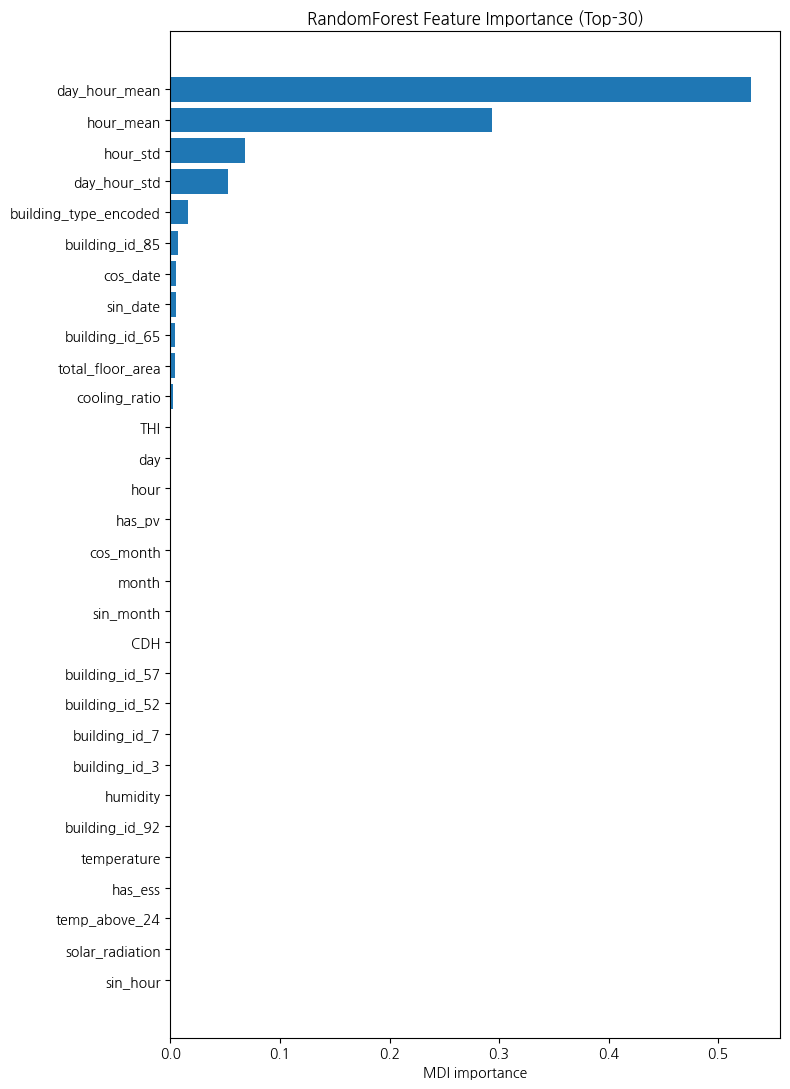

In [ ]:
# ===================== 공통 준비 =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# >>> 네 피처/타깃 (DataFrame/Series)로 바꿔줘
# 예: x_global, y_global (이전 코드 기준)
X_train = x_global.copy()        # (pd.DataFrame) 훈련용 피처
y_train = y_global.copy()        # (pd.Series)   훈련용 타깃 (원 스케일)
# 검증셋이 따로 있으면 X_val, y_val 지정. 없으면 X_train, y_train을 임시로 사용.
X_val   = X_train
y_val   = y_train

# 로그 타깃으로 학습 (네 파이프라인과 동일)
y_train_log = np.log1p(y_train)

# 랜덤포레스트(일반화 지향) 하이퍼파라미터
rf_params = dict(
    n_estimators=1200,
    max_depth=None,
    max_features=0.5,
    min_samples_leaf=5,
    min_samples_split=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# 중요도 계산용 모델(전체 데이터 학습)
rf = RandomForestRegressor(**rf_params).fit(X_train.values, y_train_log.values)

# ===================== (A) 기본 중요도 (MDI) =====================
feat_names = X_train.columns.to_list()
mdi = pd.DataFrame({
    "feature":  feat_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("== RandomForest Feature Importance (MDI) ==")
print(mdi.head(30))

# 시각화 (Top-30)
topN = 30
plt.figure(figsize=(8, min(0.3*topN+2, 12)))
plt.barh(mdi["feature"].head(topN)[::-1], mdi["importance"].head(topN)[::-1])
plt.xlabel("MDI importance")
plt.title(f"RandomForest Feature Importance (Top-{topN})")
plt.tight_layout()
plt.show()

# ===================== (B) 퍼뮤테이션 중요도 =====================
# 퍼뮤테이션 스코어는 기본 R^2를 쓰거나, 네 지표(SMAPE)를 쓸 수도 있어.
# (i) 로그-스케일 R^2 (간단)
# r = permutation_importance(rf, X_val.values, np.log1p(y_val.values),
#                            scoring="r2", n_repeats=10, random_state=42, n_jobs=-1)

# (ii) 원 스케일 SMAPE로 평가하고 싶으면 커스텀 스코어러 사용
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def smape_from_log(y_true, y_pred_log):
    # 모델 예측이 log 스케일이므로 expm1로 되돌려서 SMAPE 계산
    return smape(y_true, np.expm1(y_pred_log))

smape_scorer = make_scorer(smape_from_log, greater_is_better=False)
r = permutation_importance(
    rf, X_val.values, y_val.values,
    scoring=smape_scorer, n_repeats=10, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": feat_names,
    "mean_importance": r.importances_mean,     # 점수가 "얼마나 떨어졌는지" → 절댓값이 클수록 중요
    "std": r.importances_std
}).sort_values("mean_importance", ascending=False)

print("== Permutation Importance (by SMAPE drop; larger is more important) ==")
print(perm_df.head(30))

# 시각화 (Top-30)
plt.figure(figsize=(8, min(0.3*topN+2, 12)))
plt.barh(perm_df["feature"].head(topN)[::-1], perm_df["mean_importance"].head(topN)[::-1])
plt.xlabel("Permutation importance (SMAPE drop; higher is worse when permuted)")
plt.title(f"Permutation Importance (Top-{topN})")
plt.tight_layout()
plt.show()

